# 4. Fraud Detection (K-mean)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [16]:
loandata = pd.DataFrame(pd.read_csv('cleaned_loan_data.csv'))
loandata.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,assets,loan_status
0,2,1,0,9600000,29900000,12,778,50700000,1
1,0,0,1,4100000,12200000,8,417,17000000,0
2,3,1,0,9100000,29700000,20,506,57700000,0
3,3,1,0,8200000,30700000,8,467,52700000,0
4,5,0,1,9800000,24200000,20,382,55000000,0


# Train the Model

In [17]:
# Select key features for fraud detection
x = loandata[["income_annum", "loan_amount", "cibil_score", "assets"]]

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [18]:
# try to find the optimal number of clusters
wcss = []
k_values = range(1, 11)
for k in k_values: 
    model_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    model_k.fit(x_scaled)
    wcss.append(model_k.inertia_)

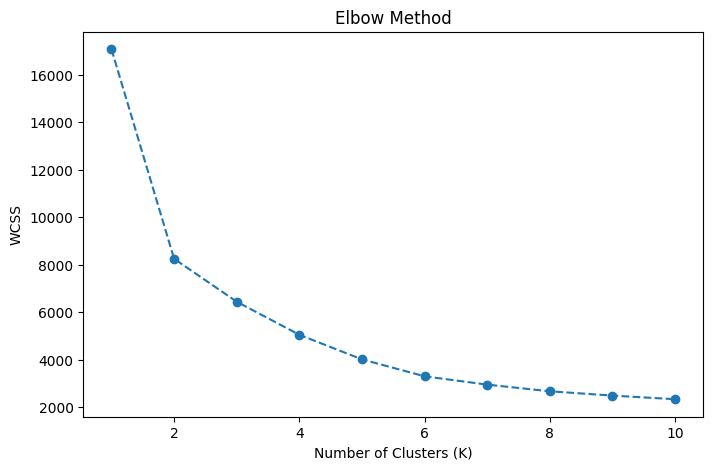

In [19]:
# Draw the Elbow to find the optimal number for K
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [20]:
# Apply K-Means Clustering
model = KMeans(n_clusters=2, random_state=42, n_init=10)
loandata["Cluster"] = model.fit_predict(x_scaled)

In [32]:
# Compute the distance of each point from its cluster center
loandata["Dist_clu_cen"] = np.linalg.norm(x_scaled - model.cluster_centers_[loandata["Cluster"]], axis=1)

# calculate the threshold (I will assume this bank counts top 6% farthest points as fraud points)
# threshold is the distance of closest 95% of points to their cluster center
threshold = np.percentile(loandata["Dist_clu_cen"], 95)
loandata["Fraud_Flag"] = loandata["Dist_clu_cen"] > threshold  # True = Potential Fraud

threshold
#save the threshold value
np.save('frud_threshold.npy', threshold)

In [33]:
# Show fraud detection summary
fraud_cases = loandata[loandata["Fraud_Flag"] == True]
print(f"Potential Fraud Cases Detected: {len(fraud_cases)}")
print(fraud_cases[["income_annum", "loan_amount", "cibil_score", "assets", "Fraud_Flag"]])

Potential Fraud Cases Detected: 214
      income_annum  loan_amount  cibil_score    assets  Fraud_Flag
5          4800000     13500000          319  33900000        True
12         5000000     11600000          311  34900000        True
29         9000000     31500000          850  75900000        True
57         9300000     30500000          841  72900000        True
95          300000      1100000          300   1700000        True
...            ...          ...          ...       ...         ...
4173       8800000     29800000          343  70400000        True
4191       9900000     37300000          385  43100000        True
4197       8600000     23200000          894  69700000        True
4258       9700000     22600000          346  76200000        True
4263       5000000     12700000          865  38600000        True

[214 rows x 5 columns]


In [ ]:
# Visualize fraud detection (scatter plot)
plt.figure(figsize=(8,6))
sns.scatterplot(x=loandata["income_annum"], y=loandata["loan_amount"], hue=loandata["Fraud_Flag"], palette={True: "red", False: "blue"})
plt.xlabel("Annual Income")
plt.ylabel("Loan Amount")
plt.title("Fraud Detection Based on Income vs Loan Amount")
plt.legend(title="Fraud Flag")
plt.show()

In [ ]:
# Visualize fraud detection (scatter plot)
plt.figure(figsize=(8,6))
sns.scatterplot(x=loandata["loan_amount"], y=loandata["cibil_score"], hue=loandata["Fraud_Flag"], palette={True: "red", False: "blue"})
plt.xlabel("Loan Amount")
plt.ylabel("CIBIL Score")
plt.title("Fraud Detection Based on Loan Amount vs CIBIL Score")
plt.legend(title="Fraud Flag")
plt.show()

In [ ]:
# Visualize fraud detection (scatter plot)
plt.figure(figsize=(8,6))
sns.scatterplot(x=loandata["assets"], y=loandata["loan_amount"], hue=loandata["Fraud_Flag"], palette={True: "red", False: "blue"})
plt.xlabel("Assets")
plt.ylabel("Loan Amount")
plt.title("Fraud Detection Based on Assets vs Loan Amount")
plt.legend(title="Fraud Flag")
plt.show()

In [ ]:
# Do a test prediction
test_data = [[100000, 50000, 600, 200000]]
test_data_scaled = scaler.transform(test_data)

test_cluster = model.predict(test_data_scaled)
test_distance = np.linalg.norm(test_data_scaled - model.cluster_centers_[test_cluster])
test_fraud = test_distance > threshold
print(f"Test Fraud: {test_fraud}")

# Build the Model

In [ ]:
import pickle as pk
pk.dump(model, open('model_4.pkl','wb'))
pk.dump(scaler, open('scaler_4.pkl','wb'))